___
#### Instalação dos módulos necessários

In [ ]:
%pip install duckdb
%pip install imbalanced-learn
%pip install keras
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install pydot
%pip install scikit-learn
%pip install seaborn
%pip install warnings

#### Importação dos módulos necessários

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import duckdb as ddb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from Custom import Custom_LSTM as CL

#### Ignora warnings que serão gerados

In [2]:
warnings.filterwarnings("ignore")

___

#### Leitura e análise do conjunto de treino das ações do Banco do Brasil (BBAS3)

In [3]:
raw_bbas3_train = pd.read_csv("_datasets/bbas3/treino.csv")
raw_bbas3_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4730,4731,2019-03-19,39.001053,38.947137,1,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,39.212849
4731,4732,2019-03-20,38.126942,38.865118,-1,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271
4732,4733,2019-03-21,37.326935,38.711299,-1,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073
4733,4734,2019-03-22,35.297241,38.369894,-1,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908
4734,4735,2019-03-25,35.549099,38.087814,-1,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [4]:
spec_bbas3_train = raw_bbas3_train.drop(columns="Smoothed_Close")
spec_bbas3_train = spec_bbas3_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_bbas3_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4730,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,39.212849,1
4731,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,-1
4732,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,-1
4733,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,-1
4734,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,-1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [5]:
spec_bbas3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4735 non-null   float64
 1   Past_1_Days_Close   4735 non-null   float64
 2   Past_2_Days_Close   4735 non-null   float64
 3   Past_3_Days_Close   4735 non-null   float64
 4   Past_4_Days_Close   4735 non-null   float64
 5   Past_5_Days_Close   4735 non-null   float64
 6   Past_6_Days_Close   4735 non-null   float64
 7   Past_7_Days_Close   4735 non-null   float64
 8   Past_8_Days_Close   4735 non-null   float64
 9   Past_9_Days_Close   4735 non-null   float64
 10  Past_10_Days_Close  4735 non-null   float64
 11  Past_11_Days_Close  4735 non-null   float64
 12  Past_12_Days_Close  4735 non-null   float64
 13  Past_13_Days_Close  4735 non-null   float64
 14  Past_14_Days_Close  4735 non-null   float64
 15  Past_15_Days_Close  4735 non-null   float64
 16  Label 

Conforme apresentado acima, notamos que nenhuma das variáveis apresenta valores nulos, portanto, neste momento, não precisaremos remover ou realizar a inputação de valores como tratamento a valores ausentes.  

Dessa forma, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [6]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_bbas3_train GROUP BY 1""").to_df()
size = spec_bbas3_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4735 registros, onde:
 -> Vendas: 2602 ou 54.95%
 -> Compras: 2133 ou 45.05%


O conjunto de dados de treino apresenta uma boa distribuição entre as classes, sendo assim, não será necessário aplicar nenhuma técnica de amostragem para balancear os dados, o que geralmente é feito para evitar que o modelo tornesse especialista em uma única classe.

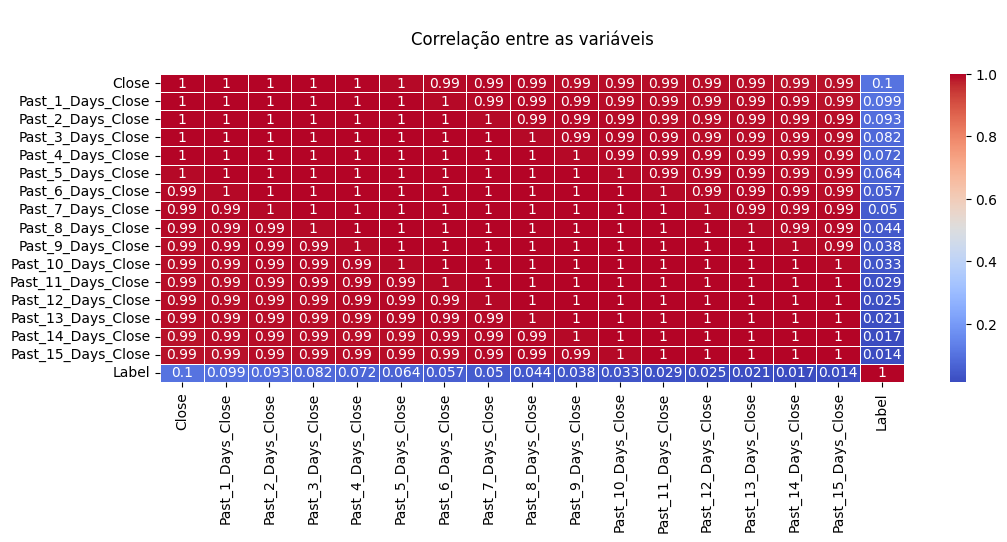

In [7]:
correlation = spec_bbas3_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Além disso, há outros dois comportamentos importantes a serem notados:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações do Banco do Brasil (BBAS3)

In [8]:
raw_bbas3_test = pd.read_csv("_datasets/bbas3/teste.csv")
raw_bbas3_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1180,5916,2023-12-21,54.290001,53.331493,1,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764
1181,5917,2023-12-22,54.439999,53.442343,1,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074
1182,5918,2023-12-26,54.939999,53.592109,1,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391
1183,5919,2023-12-27,54.860001,53.718898,1,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391
1184,5920,2023-12-28,55.389999,53.886008,1,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [9]:
spec_bbas3_test = raw_bbas3_test.drop(columns="Smoothed_Close")
spec_bbas3_test = spec_bbas3_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_bbas3_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1180,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764,1
1181,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,1
1182,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,1
1183,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,1
1184,55.389999,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,1


Com o tratamento realizado, analisaremos se de fato não existem informações nulas no conjunto de dados de teste.

In [10]:
spec_bbas3_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1185 non-null   float64
 1   Past_1_Days_Close   1185 non-null   float64
 2   Past_2_Days_Close   1185 non-null   float64
 3   Past_3_Days_Close   1185 non-null   float64
 4   Past_4_Days_Close   1185 non-null   float64
 5   Past_5_Days_Close   1185 non-null   float64
 6   Past_6_Days_Close   1185 non-null   float64
 7   Past_7_Days_Close   1185 non-null   float64
 8   Past_8_Days_Close   1185 non-null   float64
 9   Past_9_Days_Close   1185 non-null   float64
 10  Past_10_Days_Close  1185 non-null   float64
 11  Past_11_Days_Close  1185 non-null   float64
 12  Past_12_Days_Close  1185 non-null   float64
 13  Past_13_Days_Close  1185 non-null   float64
 14  Past_14_Days_Close  1185 non-null   float64
 15  Past_15_Days_Close  1185 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de teste é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [11]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_bbas3_test GROUP BY 1""").to_df()
size = spec_bbas3_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1185 registros, onde:
 -> Vendas: 689 ou 0.58%
 -> Compras: 496 ou 0.42%


Diferente do conjunto de treino, onde tivemos cerca de 55% de vendas e 45% de compras, o conjunto de teste apresentou aproximadamente 42% de vendas e 58% de compras, ou seja, tivemos uma mudança significativa na volumetria das classes, o que pode ocasionar em uma perda de precisão do modelo.

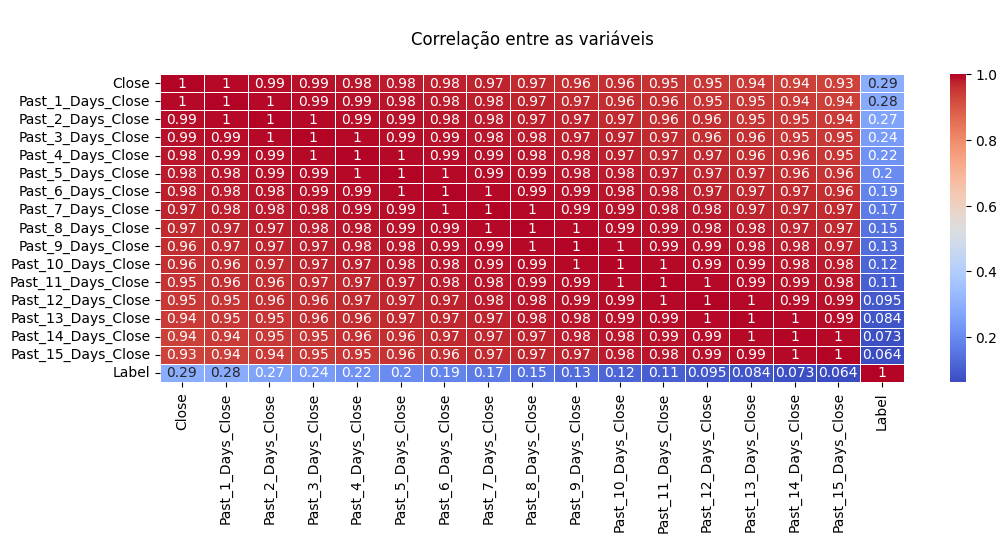

In [12]:
correlation = spec_bbas3_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Além disso, note que as mesmas observações realizadas na matriz de correlação das variáveis do conjunto de treino também estão presentes no conjunto de teste, ou seja, mesmo que baixa, há uma correlação entre a variável alvo e o valor do fechamento das ações nos últimos 15 dias.

#### Modelagem e avaliação dos resultados

In [13]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_bbas3_train['Label'].unique())}\n -> Teste: {list(spec_bbas3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [-1, 1]
 -> Teste: [-1, 1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [14]:
spec_bbas3_train["Label"] = spec_bbas3_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_bbas3_test["Label"] = spec_bbas3_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_bbas3_train['Label'].unique())}\n -> Teste: {list(spec_bbas3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [0, 1]
 -> Teste: [0, 1]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [15]:
x_train_bbas3 = np.array(spec_bbas3_train.drop(columns=["Label"]))
x_test_bbas3 = np.array(spec_bbas3_test.drop(columns=["Label"]))

x_standard_train_bbas3 = np.array(StandardScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_standard_test_bbas3 = np.array(StandardScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_minmax_train_bbas3 = np.array(MinMaxScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_minmax_test_bbas3 = np.array(MinMaxScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_robust_train_bbas3 = np.array(RobustScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_robust_test_bbas3 = np.array(RobustScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_list_train_bbas3 = [["Não", x_train_bbas3], ["Standard", x_standard_train_bbas3], ["Minmax", x_minmax_train_bbas3], ["Robust", x_robust_train_bbas3]]
x_list_test_bbas3 = [["Não", x_test_bbas3], ["Standard", x_standard_test_bbas3], ["Minmax", x_minmax_test_bbas3], ["Robust", x_robust_test_bbas3]]

y_train_bbas3 = np.array(spec_bbas3_train["Label"])
y_test_bbas3 = np.array(spec_bbas3_test["Label"])

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.

In [16]:
grid_bbas3 = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size_bbas3 = len(grid_bbas3)

In [17]:
# Inicializa variáveis auxiliares
network_index_bbas3 = 0

# Instancia o modelo
lstm_bbas3 = CL()

# Percorre o grid de treinos
for i in range(grid_size_bbas3):
    # Percorre a lista de normalizações de treino
    for x_i_train_bbas3, x_i_test_bbas3 in zip(x_list_train_bbas3, x_list_test_bbas3):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index_bbas3}\n -> {grid_bbas3[i][0]}x LSTM com {grid_bbas3[i][1]} neurônios\n -> {grid_bbas3[i][0]}x Dropout com rate de {round(0.1 * grid_bbas3[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train_bbas3[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm_bbas3.build_model(c_layers_number=grid_bbas3[i][0], c_units_number=grid_bbas3[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm_bbas3.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm_bbas3.fit_model(c_x=x_i_train_bbas3[1], c_y=y_train_bbas3, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm_bbas3.evaluate_model()
        lstm_bbas3.predict_model(c_x=x_i_test_bbas3[1])
        network_index_bbas3 += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.4240
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.3971
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7509 - loss: 0.4371
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.3855
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [18]:
# Inicializa variáveis auxiliares
champion_index_bbas3 = 0
current_loss_bbas3 = float("+inf")
current_accuracy_bbas3 = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i_bbas3 in range(len(lstm_bbas3.c_model_scores_train)):
    if lstm_bbas3.c_model_scores_train[i_bbas3][0] < current_loss_bbas3:
        current_loss_bbas3 = round(lstm_bbas3.c_model_scores_train[i_bbas3][0], 2)
        champion_index_bbas3 = i_bbas3
    if lstm_bbas3.c_model_scores_train[i_bbas3][1] > current_accuracy_bbas3:
        current_accuracy_bbas3 = round(lstm_bbas3.c_model_scores_train[i_bbas3][1], 2)
        champion_index_bbas3 = i_bbas3

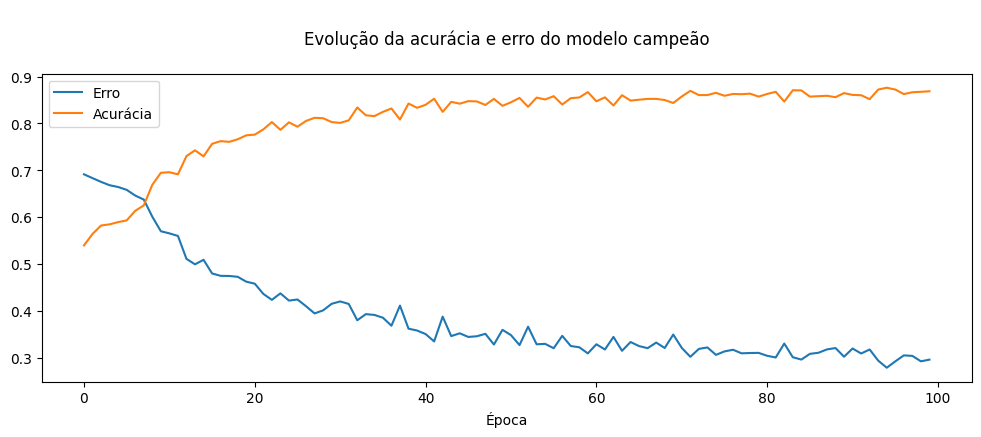

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(lstm_bbas3.c_model_statistics_train[champion_index_bbas3][1])
plt.plot(lstm_bbas3.c_model_statistics_train[champion_index_bbas3][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [20]:
y_pred_bbas3 = (lstm_bbas3.c_predicts[champion_index_bbas3] > 0.5).astype(int)
confu_matrix_bbas3 = confusion_matrix(y_test_bbas3, y_pred_bbas3)
class_report_bbas3 = classification_report(y_test_bbas3, y_pred_bbas3)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index_bbas3}\n\n -> Acurácia: {current_accuracy_bbas3}%\n\n -> Erro: {current_loss_bbas3}%\n\n -> Matriz de confusão\n{confu_matrix_bbas3}\n\n -> Reporte de classificação\n{class_report_bbas3}")


Informações do modelo campeão:

 -> Topologia: 20

 -> Acurácia: 0.88%

 -> Erro: 0.28%

 -> Matriz de confusão
[[217 472]
 [ 11 485]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.95      0.31      0.47       689
           1       0.51      0.98      0.67       496

    accuracy                           0.59      1185
   macro avg       0.73      0.65      0.57      1185
weighted avg       0.77      0.59      0.55      1185



Como apresentado acima, a 20° topologia (2x LSTM com 64 neurônios + 2x Dropout com rate de 0.2 + 1x Densa + Normalização: Não) apresentou a maior acurácia dentre as demais topologias, entretanto, apegar-se apenas a essa métrica é um erro, visto que como apresentado na matriz de confusão, grande parte das predições que deveriam ser vendas foram classificadas como compras, ou seja, estaríamos perdendo dinheiro ao comprar as ações com um alto valor.

Como hipótese inicial, entendemos que a baixa precisão para venda de ações foi ocasionada pelo desbalanceamento de classes, visto que no conjunto de treinamento a representividade foi de ~55%, enquanto que no conjunto de teste a representativa foi de apenas 42%. 

Para validar esse ponto, iremos realizaremos o balanceamento de classes para os demais conjuntos de dados das ações CSNA3, PETR4 e VALE3 para identificar possíveis mudanças.

___

#### Leitura e análise do conjunto de treino das ações da Companhia Siderúrgica Narcional (CSNA3)

In [21]:
raw_csna3_train = pd.read_csv("_datasets/csna3/treino.csv")
raw_csna3_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4738,4739,2019-03-18,10.849827,9.159503,1,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856,7.674757
4739,4740,2019-03-19,10.437135,9.287266,1,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856
4740,4741,2019-03-20,10.583574,9.416897,1,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800
4741,4742,2019-03-21,10.370573,9.512265,1,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707
4742,4743,2019-03-22,9.957878,9.556826,1,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [22]:
spec_csna3_train = raw_csna3_train.drop(columns="Smoothed_Close")
spec_csna3_train = spec_csna3_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_csna3_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4738,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856,7.674757,1
4739,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856,1
4740,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,1
4741,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,1
4742,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [23]:
spec_csna3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4743 non-null   float64
 1   Past_1_Days_Close   4743 non-null   float64
 2   Past_2_Days_Close   4743 non-null   float64
 3   Past_3_Days_Close   4743 non-null   float64
 4   Past_4_Days_Close   4743 non-null   float64
 5   Past_5_Days_Close   4743 non-null   float64
 6   Past_6_Days_Close   4743 non-null   float64
 7   Past_7_Days_Close   4743 non-null   float64
 8   Past_8_Days_Close   4743 non-null   float64
 9   Past_9_Days_Close   4743 non-null   float64
 10  Past_10_Days_Close  4743 non-null   float64
 11  Past_11_Days_Close  4743 non-null   float64
 12  Past_12_Days_Close  4743 non-null   float64
 13  Past_13_Days_Close  4743 non-null   float64
 14  Past_14_Days_Close  4743 non-null   float64
 15  Past_15_Days_Close  4743 non-null   float64
 16  Label 

Assim como o conjunto de dados de treino com as ações do BBAS3 (Banco do Brasil), não foram identificados nenhum atributo nulo nas colunas do conjunto de dados de treino com as ações da CSNA3 (Companhia Siderúrgica Nacional), dessa forma não será necessário realizar a remoção de registros ou imputar valores para completar o conjunto de dados.

Sendo assim, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [24]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_csna3_train GROUP BY 1""").to_df()
size = spec_csna3_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4743 registros, onde:
 -> Vendas: 2655 ou 55.98%
 -> Compras: 2088 ou 44.02%


O conjunto de dados de treino apresenta uma inclinação para classificar vendas, sendo assim, iremos utilizar a técnica Smote para realizar o balanceamento entre as classes quando formos treinar o modelo, evitando que o modelo torne-se especialista em uma determinada classe.

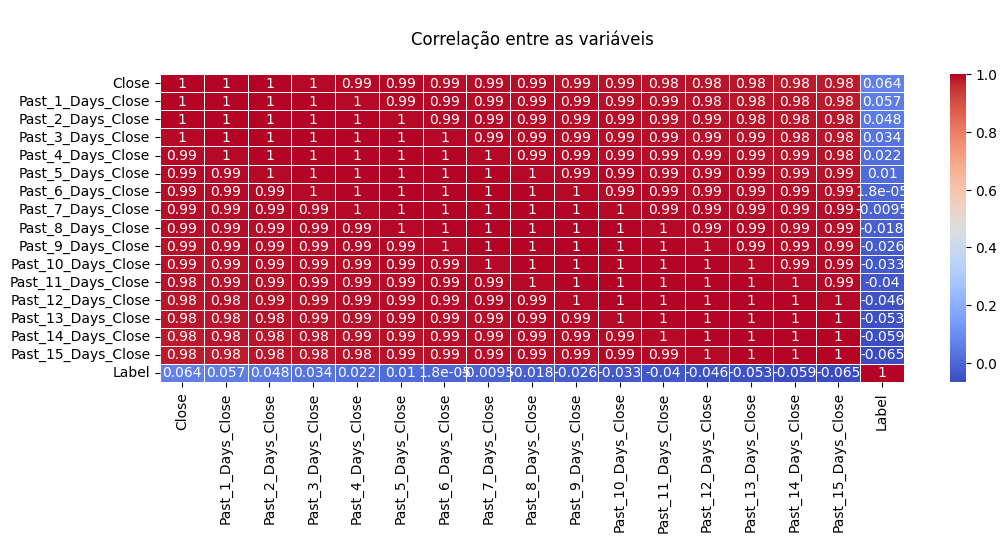

In [25]:
correlation = spec_csna3_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Assim como apresentado no conjunto de dados de treino das ações BBAS3 (Banco do Brasil), o conjunto de dados de treino das ações CSNA3 (Companhia Nacional) apresentam as seguintes características:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações da Companhia Siderúrgica Narcional (CSNA3)

In [26]:
raw_csna3_test = pd.read_csv("_datasets/csna3/teste.csv")
raw_csna3_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1181,5925,2023-12-21,19.049999,17.232923,1,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000,16.420000
1182,5926,2023-12-22,19.110001,17.420631,1,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000
1183,5927,2023-12-26,19.360001,17.614568,1,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000
1184,5928,2023-12-27,19.510000,17.804111,1,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000
1185,5929,2023-12-28,19.660000,17.989700,1,19.510000,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [27]:
spec_csna3_test = raw_csna3_test.drop(columns="Smoothed_Close")
spec_csna3_test = spec_csna3_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_csna3_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1181,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000,16.420000,1
1182,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000,1
1183,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,1
1184,19.510000,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,1
1185,19.660000,19.510000,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [28]:
spec_csna3_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1186 non-null   float64
 1   Past_1_Days_Close   1186 non-null   float64
 2   Past_2_Days_Close   1186 non-null   float64
 3   Past_3_Days_Close   1186 non-null   float64
 4   Past_4_Days_Close   1186 non-null   float64
 5   Past_5_Days_Close   1186 non-null   float64
 6   Past_6_Days_Close   1186 non-null   float64
 7   Past_7_Days_Close   1186 non-null   float64
 8   Past_8_Days_Close   1186 non-null   float64
 9   Past_9_Days_Close   1186 non-null   float64
 10  Past_10_Days_Close  1186 non-null   float64
 11  Past_11_Days_Close  1186 non-null   float64
 12  Past_12_Days_Close  1186 non-null   float64
 13  Past_13_Days_Close  1186 non-null   float64
 14  Past_14_Days_Close  1186 non-null   float64
 15  Past_15_Days_Close  1186 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de treino é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [29]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_csna3_test GROUP BY 1""").to_df()
size = spec_csna3_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1186 registros, onde:
 -> Vendas: 688 ou 0.58%
 -> Compras: 498 ou 0.42%


Assim como apresentado no conjunto de dados de teste das ações BBAS3 (Banco do Brasil), o conjunto de dados de teste das ações CSNA3 (Companhia Nacional) apresentam uma diferença significativa na distribuição das classes, entretanto, como utilizaremos a técnica SMOTE para realizar o treinamento, espera-se que o modelo apresente bons resultados e não crie viés para uma das classes.

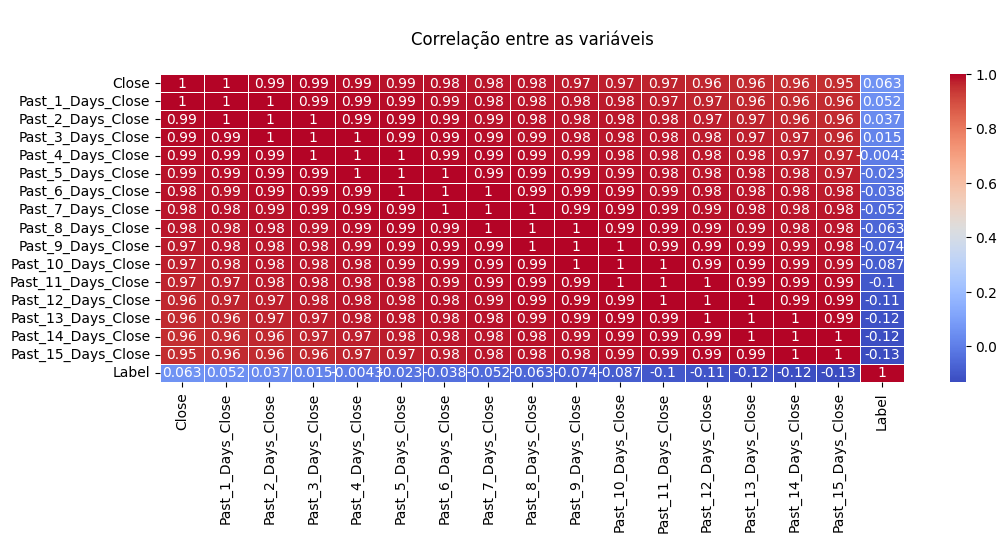

In [30]:
correlation = spec_csna3_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Perceba que, após analisarmos a matriz de correlação do conjunto de dados de teste, observamos um comportamento semelhante a matriz de correlação do conjunto de dados de treino, ou seja, uma baixíssima correlação entre a variável dependente e as variáveis independentes.

#### Modelagem e avaliação dos resultados

In [31]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_csna3_train['Label'].unique())}\n -> Teste: {list(spec_csna3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [-1, 1]
 -> Teste: [1, -1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [32]:
spec_csna3_train["Label"] = spec_csna3_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_csna3_test["Label"] = spec_csna3_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_csna3_train['Label'].unique())}\n -> Teste: {list(spec_csna3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [0, 1]
 -> Teste: [1, 0]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [70]:
# Instancia o SMOTE para realizar o balanceamento das classes do conjunto de treino
smote = SMOTE(sampling_strategy="auto", random_state=42)

x_train_csna3 = np.array(spec_csna3_train.drop(columns=["Label"]))
x_test_csna3 = np.array(spec_csna3_test.drop(columns=["Label"]))

y_train_csna3 = np.array(spec_csna3_train["Label"])
y_test_csna3 = np.array(spec_csna3_test["Label"])

# Realiza o balanceamento de classes dos conjuntos do conjunto de treino
x_train_csna3, y_train_csna3 = smote.fit_resample(x_train_csna3, y_train_csna3)

x_standard_train_csna3 = np.array(StandardScaler().fit_transform(x_train_csna3))
x_standard_test_csna3 = np.array(StandardScaler().fit_transform(x_test_csna3))

x_minmax_train_csna3 = np.array(MinMaxScaler().fit_transform(x_train_csna3))
x_minmax_test_csna3 = np.array(MinMaxScaler().fit_transform(x_test_csna3))

x_robust_train_csna3 = np.array(RobustScaler().fit_transform(x_train_csna3))
x_robust_test_csna3 = np.array(RobustScaler().fit_transform(x_test_csna3))

x_list_train_csna3 = [["Não", x_train_csna3], ["Standard", x_standard_train_csna3], ["Minmax", x_minmax_train_csna3], ["Robust", x_robust_train_csna3]]
x_list_test_csna3 = [["Não", x_test_csna3], ["Standard", x_standard_test_csna3], ["Minmax", x_minmax_test_csna3], ["Robust", x_robust_test_csna3]]

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.

In [71]:
grid_csna3 = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size_csna3 = len(grid_csna3)

In [72]:
# Inicializa variáveis auxiliares
network_index_csna3 = 0

# Instancia o modelo
lstm_csna3 = CL()

# Percorre o grid de treinos
for i in range(grid_size_csna3):
    # Percorre a lista de normalizações de treino
    for x_i_train_csna3, x_i_test_csna3 in zip(x_list_train_csna3, x_list_test_csna3):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index_csna3}\n -> {grid_csna3[i][0]}x LSTM com {grid_csna3[i][1]} neurônios\n -> {grid_csna3[i][0]}x Dropout com rate de {round(0.1 * grid_csna3[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train_csna3[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm_csna3.build_model(c_layers_number=grid_csna3[i][0], c_units_number=grid_csna3[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm_csna3.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm_csna3.fit_model(c_x=x_i_train_csna3[1], c_y=y_train_csna3, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm_csna3.evaluate_model()
        lstm_csna3.predict_model(c_x=x_i_test_csna3[1])
        network_index_csna3 += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - loss: 0.2329
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.3978
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.3176
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8915 - loss: 0.2581
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [73]:
# Inicializa variáveis auxiliares
champion_index_csna3 = 0
current_loss_csna3 = float("+inf")
current_accuracy_csna3 = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i_csna3 in range(len(lstm_csna3.c_model_scores_train)):
    if lstm_csna3.c_model_scores_train[i_csna3][0] < current_loss_csna3:
        current_loss_csna3 = round(lstm_csna3.c_model_scores_train[i_csna3][0], 2)
        champion_index_csna3 = i_csna3
    if lstm_csna3.c_model_scores_train[i_csna3][1] > current_accuracy_csna3:
        current_accuracy_csna3 = round(lstm_csna3.c_model_scores_train[i_csna3][1], 2)
        champion_index_csna3 = i_csna3

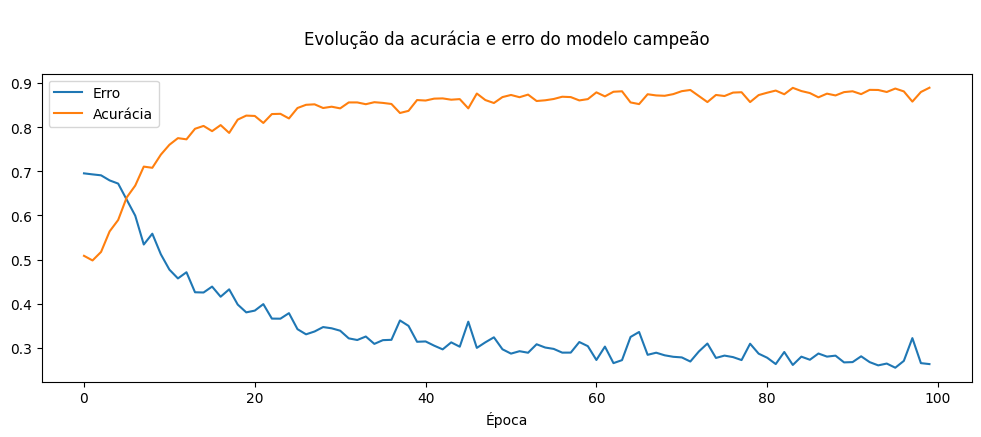

In [74]:
plt.figure(figsize=(12, 4))
plt.plot(lstm_csna3.c_model_statistics_train[champion_index_csna3][1])
plt.plot(lstm_csna3.c_model_statistics_train[champion_index_csna3][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [75]:
y_pred_csna3 = (lstm_csna3.c_predicts[champion_index_csna3] > 0.5).astype(int)
confu_matrix_csna3 = confusion_matrix(y_test_csna3, y_pred_csna3)
class_report_csna3 = classification_report(y_test_csna3, y_pred_csna3)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index_csna3}\n\n -> Acurácia: {current_accuracy_csna3}%\n\n -> Erro: {current_loss_csna3}%\n\n -> Matriz de confusão\n{confu_matrix_csna3}\n\n -> Reporte de classificação\n{class_report_csna3}")


Informações do modelo campeão:

 -> Topologia: 32

 -> Acurácia: 0.91%

 -> Erro: 0.21%

 -> Matriz de confusão
[[607  81]
 [160 338]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       688
           1       0.81      0.68      0.74       498

    accuracy                           0.80      1186
   macro avg       0.80      0.78      0.79      1186
weighted avg       0.80      0.80      0.79      1186



Como apresentado acima, a 32° topologia (3x LSTM com 64 neurônios + 3x Dropout com rate de 0.3 + 1x Densa + Normalização: Não) apresentou a maior acurácia dentre as demais topologias. Além disso, notamos que devido ao balanceamento de classes (realizado utilizando o SMOTE) tivemos uma mudança significativa quando comparamos os resultados das ações BBAS3 e CSNA3, visto que na última matriz de confusão temos menos Falsos Positivos e Falsos Negativos.